# Testing network Backpropogation

To check the network is implimented correctly we can compute the gradient and also check the numerical gradient to see if they are within a range. The numerical gradient can be computed as:

$$\frac{\partial C}{\partial \omega_i} \approx \frac{C(\omega_i + \epsilon) - C(\omega_i - \epsilon)}{2\epsilon}$$

testing with small $\epsilon$, on the order of $10^{-3} < \epsilon < 10^{-1}$ we can expect errors on the order of about $\epsilon^2$. 
Very small $\epsilon$ lead to error in the gradients which are very small and can be miscalculated due to roundoff error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simnn import Model
from simnn import Linear, PM_BN
from simnn import ReLU, Softmax, Logistic_Sigmoid
from simnn import CrossEntropy
from simnn.utils import one_hot

from dataset.mnist.mnist import load_mnist_data
from dataset.utils import *

from tests import _numerical_grad

In [2]:
# Extract data
((X_train, Y_train), (X_test, Y_test)) = load_mnist_data('dataset/mnist/')

[X_train, X_test] = d_range([X_train, X_test])  # put data values \in [-1, 1]

# create training / validatin data split
((X_train, Y_train), (X_val, Y_val)) = train_val_split((X_train, Y_train), 1 / 6)

t_train, t_val = one_hot(Y_train, m=10), one_hot(Y_val, m=10)
t_test = one_hot(Y_test, m=10)

dataset, val_set = (X_train, t_train), (X_val, t_val)
test_set = (X_test, t_test)

b_size = 512
# take out a samples for gradent check
X_check, Y_check = X_train[0:b_size], t_train[0:b_size]

In [3]:
Model._numerical_grad = _numerical_grad
Model.nu = 1e-3

In [4]:
# define model structure
nh = 64
layers = [Linear(out_shape=nh, activation=Logistic_Sigmoid(),
                 bias=True, init='lecun_normal'),
          PM_BN(nh),
          Linear(out_shape=10, activation=Softmax(), bias=True,
                 init='lecun_normal')]

# instantiate model
model = Model(layers, dataset, CrossEntropy(), class_task=True)

model.fit((X_check, Y_check),3, verbose=False)

In [5]:
configs = [(0, False, (0, 0)),
           (0, False, (60, 62)),
           (3, False, (0, 0)),
           (3, False, (4, 6)),
           (0, False, (10, 26)),
           (3, False, (7, 3)),
           (0, True, (0)),
           (0, True, (20)),
           (3, True, (0)),
           (3, True, (5))]
eps = np.arange(.001, .1, .0001)
dw_error = []
for config in configs:
    dw_e = []
    for ep in eps:
        e = model._numerical_grad((X_check, Y_check), config, ep)
        dw_e += [e]
    dw_error += [dw_e]

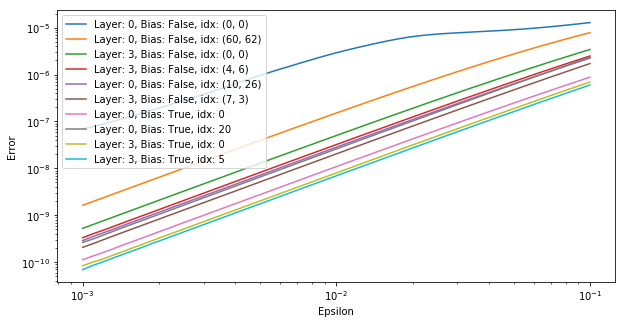

In [6]:
# plot Accuracies
plt.figure(figsize=(10,5))
for config, dw_e in zip(configs, dw_error):
    plt.plot(eps, dw_e, label='Layer: {}, Bias: {}, idx: {}'.format(config[0], config[1], config[2]))
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [7]:
dw_error = np.array(dw_error)
assert (dw_error < (eps**2)).all()